In [7]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import sys
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import csv
from collections import Counter
import matplotlib.cm as cm
from sklearn.cluster import AgglomerativeClustering
from itertools import chain, combinations
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import Birch
import itertools
import time
import re

In [8]:
########################## Helper functions #############################

def decode(labels):
    """
    Decode labels from byte to string.
    
    Returns a list of decoded label strings
    
    Arguements:
        labels: list of strings of labels
    """
    encoding = 'utf-8'
    labels = [str(x, encoding) for x in labels]
    label_decoded = [x.replace('_', ' ') for x in labels]
    
    return label_decoded

def get_labels_idx(keys, raw_labels):
    """
    Creates a dictionary of professions and the corresponding faces
    represented by the indicies of the embeddings for the labels.
    
    Returns a dictionrary of professions and corresponding indices
    
    Arguements:
        keys: a list of professions
        raw_labels: list of strings of labels
    """
    # key: profession
    # value: indices of images
    labels = {}

    for i in range(len(raw_labels)):
        for k in keys:
            # If a substring of the profession is seen in the label
            if k in raw_labels[i]:
                # If the profession is not yet a key in the dict
                if k not in labels:
                    # Add the profession as a key to the dict and it's index
                    labels[k] = [i]
                else:
                    # Otherwise append the indices corresponding to the profession
                    labels[k].append(i)
                    
    return labels

def get_clusters_dict(labels):
    """
    Creates a dictionary of professions and the corresponding faces
    represented by the indicies of the embeddings for labels from
    the clustering algorithms
    
    Returns a dictionrary 
    
    Arguements:
        keys: a list of professions
        raw_labels: list of strings of labels
    """
    # key: label
    # value: indices of images
    clusters = {}

    for idx, label in enumerate(labels):
        if label not in clusters:
            # The label is seen for first time, create a new list.
            clusters[label] = [idx]
        else:
            clusters[label].append(idx)
            
    return clusters

# Create label pairs

def create_label_pairs(labels):
    """
    Creates a list of face pairs based on the labels
    or clustering output for evaluation.
    
    Returns a list of tuples representing the face pairs 
    
    Arguements:
        labels: list of integer of labels
    """
    
    label_pairs = {}
    
    # Create pairs of 2 based on the labels
    for key, value in labels.items():
        label_pairs[key] = list(itertools.combinations(value, 2)) 
        
    label_pairs_concat = []

    # Concatenate all the face pairs for each profession
    for key, value in label_pairs.items():
        label_pairs_concat += value
        
    return label_pairs_concat

In [10]:
########################## Evaulation functions for Pairwise F-Measure #############################

def evaluate(true_labels, cluster_labels):
    """
    Computes the F-Measure, Precision, and Recall
    
    Returns three floats 
    
    Arguements:
        true_labels: a list of tuples from the actual labels
        cluster_labels: a list of tuples from the clustering output
    """
    
    # Compute interesection
    true_positive = list(set(true_labels).intersection(cluster_labels))
    # Compute set differences
    false_positive = list(set(cluster_labels) - set(true_labels))
    false_negative = list(set(true_labels) - set(cluster_labels))

    # Get the total number of TP, FP, and FN
    TP = len(true_positive)
    FP = len(false_positive)
    FN = len(false_negative)
    
    # Compute precision, recall, and F-measure
    precision = round(TP/(TP+FP), 3)
    recall = round(TP/(TP+FN), 3)
    f_measure = round(2*((precision*recall)/(precision+recall)), 3)
    
    return f_measure, precision, recall
    
def evaluate_average(true_label_pairs, num_clusters, num_iter, algo):
    """
    Evaluates the average F-measure, Precision, and Recall by running
    the experiment n times.
    
    Returns void 
    
    Arguements:
        true_labels: a list of tuples from the actual labels
        num_clusters: integer
        algo: string - type of clustering algorithm
    """
    
    cumulative_f_measure = 0
    cumulative_precision = 0
    cumulative_recall = 0
    cumulative_runtime = 0
    
    # Run the experiment n times
    for i in range(num_iter):
        # K-Means Clustering
        if algo == "Kmeans":
        
            start = time.time()
            # Clustering
            kmeans = KMeans(n_clusters = num_clusters).fit(X)
            runtime = round((time.time() - start), 3)
            # Get face pairs from labels
            k_means_clusters = get_clusters_dict(kmeans.labels_)
            cluster_label_pairs = create_label_pairs(k_means_clusters)
        
        # HAC Clustering
        elif algo == "HAC":
            start = time.time()
            # Clustering
            clustering = AgglomerativeClustering(n_clusters=num_clusters, distance_threshold=None).fit(X)
            runtime = round((time.time() - start), 3)
            # Get face pairs from labels
            hac_clusters = get_clusters_dict(clustering.labels_)
            cluster_label_pairs = create_label_pairs(hac_clusters)
                            
        # Spectral Clustering   
        elif algo == "Spectral":
            
            start = time.time()
            # Clustering
            clustering = SpectralClustering(n_clusters=num_clusters).fit(X)
            runtime = round((time.time() - start), 3)
            # Get face pairs from labels
            spectral_cluster = get_clusters_dict(clustering.labels_)
            cluster_label_pairs = create_label_pairs(spectral_cluster)
        
        # EM-Clustering
        elif algo == "GMM":
            start = time.time()
            # Clustering
            gmm_labels = GaussianMixture(n_components=num_clusters, init_params='kmeans').fit_predict(X)
            runtime = round((time.time() - start), 3)
            # Get face pairs from labels
            gmm_clusters = get_clusters_dict(gmm_labels)
            cluster_label_pairs = create_label_pairs(gmm_clusters)
        
        # Birch Clustering
        elif algo == "Birch":
            
            start = time.time()
            # Clustering
            brc = Birch(n_clusters=num_clusters, compute_labels=True).fit(X) 
            birch_labels = brc.predict(X)
            runtime = round((time.time() - start), 3)
            # Get face pairs from labels
            birch_clusters = get_clusters_dict(birch_labels)
            cluster_label_pairs = create_label_pairs(birch_clusters)
            
        # Compute f-measure, precision, and recall
        f_measure, precision, recall = evaluate(true_label_pairs, cluster_label_pairs)
            
        # Add to cumulative
        cumulative_f_measure += f_measure
        cumulative_precision += precision
        cumulative_recall += recall
        cumulative_runtime += runtime
    
    # Compute average
    avg_f_measure = round(cumulative_f_measure/num_iter, 3)
    avg_precision = round(cumulative_precision/num_iter, 3)
    avg_recall = round(cumulative_recall/num_iter, 3)
    avg_runtime = round(cumulative_runtime/num_iter, 3)
            
    print("{} Average F-Measure: {}".format(algo, avg_f_measure))
    print("{} Average Precision: {}".format(algo, avg_precision))
    print("{} Average Recall: {}".format(algo, avg_recall))
    print("{} Average Runtime: {}".format(algo, avg_runtime))

In [12]:
########################## Load embeddings from FaceNet #############################

## Experiment 1
# facenet_embeddings = np.load("embeddings/experiment1/facenet/ex1_facenet_embeddings.npy")
# label_strings = np.load("embeddings/experiment1/facenet/ex1_facenet_label_strings.npy")

## Experiment 2
# facenet_embeddings = np.load("embeddings/experiment2/facenet/ex2_facenet_embeddings.npy")
# label_strings = np.load("embeddings/experiment2/facenet/ex2_facenet_label_strings.npy")

## Experiment 3
facenet_embeddings = np.load("embeddings/experiment3/facenet/ex3_facenet_embeddings.npy")
label_strings = np.load("embeddings/experiment3/facenet/ex3_facenet_label_strings.npy")

# convert labels from byte to string
facenet_raw_labels = decode(label_strings)

print(facenet_embeddings.shape)
#print(facenet_raw_labels)

(4593, 512)


In [13]:
########################## Load embeddings from Dlib #############################

## Experiment 1
# dlib_embeddings = np.load("embeddings/experiment1/dlib/ex1_dlib_embeddings.npy")
# dlib_raw_labels = np.load("embeddings/experiment1/dlib/ex1_dlib_names.npy")

## Experiment 2
# dlib_embeddings = np.load("embeddings/experiment2/dlib/ex2_dlib_embeddings.npy")
# dlib_raw_labels = np.load("embeddings/experiment2/dlib/ex2_dlib_names.npy")

## Experiment 3
dlib_embeddings = np.load("embeddings/experiment3/dlib/ex3_dlib_embeddings.npy")
dlib_raw_labels = np.load("embeddings/experiment3/dlib/ex3_dlib_names.npy")

dlib_raw_labels = [re.sub(".png", "", x) for x in dlib_raw_labels]
dlib_raw_labels = [re.sub(".jpg", "", x) for x in dlib_raw_labels]
dlib_raw_labels = [re.sub("_", " ", x) for x in dlib_raw_labels]

print(dlib_embeddings.shape)

#print(dlib_raw_labels)

(4593, 128)


In [16]:
########################## Load embeddings from OpenFace #############################

## Experiment 1
# data = list(csv.reader(open("embeddings/experiment1/openface/ex1_openface_reps.csv")))
# label_s = list(csv.reader(open("embeddings/experiment1/openface/ex1_openface_labels.csv")))

## Experiment 2
# data = list(csv.reader(open("embeddings/experiment2/openface/ex2_openface_reps.csv")))
# label_s = list(csv.reader(open("embeddings/experiment2/openface/ex2_openface_labels.csv")))

## Experiment 3
data = list(csv.reader(open("embeddings/experiment3/openface/ex3_openface_reps.csv")))
label_s = list(csv.reader(open("embeddings/experiment3/openface/ex3_openface_labels.csv")))

# Convert embeddings to list of floats
openface_embeddings = np.asarray(data, dtype=float)
# Get labels
openface_raw_labels = []
for i in range(len(label_s)):
    openface_raw_labels.append(label_s[i][1])

# Strip path from the labesl
## Experiment 1
#openface_raw_labels = [re.sub("./datasets/data1_aligned/", "", x) for x in openface_raw_labels]
## Experiment 2
#openface_raw_labels = [re.sub("./datasets/ex2_openface_aligned/", "", x) for x in openface_raw_labels]
## Experiment 3
openface_raw_labels = [re.sub("./datasets/ex3_openface_aligned/", "", x) for x in openface_raw_labels]

# Strip special characters
openface_raw_labels = [re.sub("(?=\/).*$", "", x) for x in openface_raw_labels]
openface_raw_labels = [re.sub("_", " ", x) for x in openface_raw_labels]

print(openface_embeddings.shape)
#print(openface_raw_labels)

(4593, 128)


In [17]:
########################## Load embeddings from ArcFace #############################

## Experiment 1
arcface_embeddings = np.load("embeddings/experiment1/arcface/embeddings.npy")
arcface_raw_labels = np.load("embeddings/experiment1/arcface/names.npy")

## Experiment 2
# arcface_embeddings = np.load("embeddings/experiment2/arcface/ex2_arcface_embeddings.npy")
# arcface_raw_labels = np.load("embeddings/experiment2/arcface/ex2_arcface_names.npy")

## Experiment 3
# arcface_embeddings = np.load("embeddings/experiment3/arcface/ex3_arcface_embeddings.npy")
# arcface_raw_labels = np.load("embeddings/experiment3/arcface/ex3_arcface_names.npy")

# convert lables from byte to string
arcface_raw_labels = decode(arcface_raw_labels)
# strip extensions of filenames from labels
arcface_raw_labels = [re.sub(".png", "", x) for x in arcface_raw_labels]
arcface_raw_labels = [re.sub(".jpg", "", x) for x in arcface_raw_labels]

print(arcface_embeddings.shape)
#print(arcface_raw_labels)

(2180, 512)


In [18]:
########################## Select feature extraction method #############################

# List of professions
keys = ["tennis", "basketball", "golf", "military officer", "politician", \
       "manager", "soccer", "architect", \
       "coach", "actor", "lawyer", "entrepreneur", "fighter", "musician"]

# Get label/index dictionary
facenet_labels = get_labels_idx(keys, facenet_raw_labels)
openface_labels = get_labels_idx(keys, openface_raw_labels)
dlib_labels = get_labels_idx(keys, dlib_raw_labels)
arcface_labels = get_labels_idx(keys, arcface_raw_labels)

# Choose method
feature_extraction_method = "facenet"

if feature_extraction_method == "openface":

    X = openface_embeddings
    # Create ground truth pairs for evaulation
    true_label_pairs = create_label_pairs(openface_labels)
    
elif feature_extraction_method == "facenet":
    
    X = facenet_embeddings
    # Create ground truth pairs for evaulation
    true_label_pairs = create_label_pairs(facenet_labels)

elif feature_extraction_method == "dlib":
    
    X = dlib_embeddings
    # Create ground truth pairs for evaulation
    true_label_pairs = create_label_pairs(dlib_labels)
    
elif feature_extraction_method == "arcface":
    
    X = arcface_embeddings
    # Create ground truth pairs for evaulation
    true_label_pairs = create_label_pairs(arcface_labels)

In [22]:
########################## Number of faces per profession #############################
for key, value in facenet_labels.items():
    print(key)
    print(len(value))
print("Number of professions: " + str(len(facenet_labels)))

soccer
450
manager
371
musician
375
actor
403
entrepreneur
485
politician
449
fighter
537
military officer
407
coach
334
architect
388
lawyer
394
Number of professions: 11


In [8]:
########################## Cluster and Evaluate #############################

num_clusters = 5
num_iter = 10

evaluate_average(true_label_pairs, num_clusters, num_iter, "Kmeans")
print()
evaluate_average(true_label_pairs, num_clusters, num_iter, "HAC")
print()
evaluate_average(true_label_pairs, num_clusters, num_iter, "Spectral")
print()
evaluate_average(true_label_pairs, num_clusters, num_iter, "GMM")
print()
evaluate_average(true_label_pairs, num_clusters, num_iter, "Birch")

Kmeans Average F-Measure: 0.509
Kmeans Average Precision: 0.58
Kmeans Average Recall: 0.454
Kmeans Average Runtime: 2.37

HAC Average F-Measure: 0.413
HAC Average Precision: 0.459
HAC Average Recall: 0.376
HAC Average Runtime: 1.013

Spectral Average F-Measure: 0.466
Spectral Average Precision: 0.532
Spectral Average Recall: 0.415
Spectral Average Runtime: 1.352

GMM Average F-Measure: 0.508
GMM Average Precision: 0.579
GMM Average Recall: 0.452
GMM Average Runtime: 1.741

Birch Average F-Measure: 0.453
Birch Average Precision: 0.473
Birch Average Recall: 0.434
Birch Average Runtime: 2.69


In [52]:
########################## Analyze TP, FP, FN with FaceNet and K-Means #############################

# K-means 
num_clusters = 2
start_time = time.time()
kmeans = KMeans(n_clusters = num_clusters).fit(X)
k_means_clusters = get_clusters_dict(kmeans.labels_)
kmeans_label_pairs = create_label_pairs(k_means_clusters)

# Find error pairs
true_positive = list(set(true_label_pairs).intersection(kmeans_label_pairs))
false_positive = list(set(kmeans_label_pairs) - set(true_label_pairs))
false_negative = list(set(true_label_pairs) - set(kmeans_label_pairs))

# Get 200 pairs of true positives
tp = true_positive[:200]

# Get 200 pairs of false positives
f = false_positive[:200]

# Get 200 pairs of false negatives
n = false_negative[:200]

# Get true positives
for pair in tp:
    print(facenet_raw_labels[pair[0]])
    print(facenet_raw_labels[pair[1]])
    print()

Elijah Wald musician
Jamie Mc Menemy musician

Peter Dewald manager
Reinhard Wolf manager

Markus Orth manager
Peer M. Schatz manager

Alfonso Fraga lawyer
Stephan Kinsella lawyer

Doc Rivers coach
Steve Sarkisian coach

Claus Friedrich Holtmann manager
Petr Miller manager

Hani Rashid architect
Hassa Horn architect

Frank Witzel musician
Manuel Stahlberger musician

Franco Iseppi manager
Pål Sæther Eiden manager

AlvaroODRIOZOLA soccer
AronGUNNARSSON soccer

Cody Stamann fighter
Lazar  Stojadinovic fighter

Lyoto Machida fighter
TJ Dillashaw fighter

Devin Clark fighter
Ryan Spann fighter

Beneil Dariush fighter
Jimi Manuwa fighter

Chad Mendes fighter
Nick Hein fighter

AdilRAMI soccer
MbarkBOUSSOUFA soccer

FedorSMOLOV soccer
PiotrZIELINSKI soccer

Chase Sherman fighter
Gilbert Burns fighter

Arthur Hiller entrepreneur
Bernie Coulson entrepreneur

Joshua Marquis lawyer
Robert A. Altman lawyer

Glen Velez musician
Kjetil Aamann musician

Abel Trujillo fighter
Dong Hyun Kim fighter

J

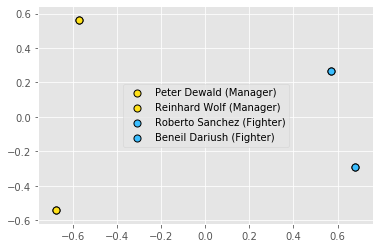

In [69]:
######################### Analyze TP, FP, FN  ###########################

# print(facenet_raw_labels.index("Peter Dewald manager"))
# print(facenet_raw_labels.index("Reinhard Wolf manager"))
# print(facenet_raw_labels.index("Roberto Sanchez fighter"))
# print(facenet_raw_labels.index("Beneil Dariush fighter"))

plot_embeddings = []
plot_embeddings.append(facenet_embeddings[3473])
plot_embeddings.append(facenet_embeddings[3644])
plot_embeddings.append(facenet_embeddings[3752])
plot_embeddings.append(facenet_embeddings[496])

plot_labels = []

plot_labels.append(kmeans.labels_[3473])
plot_labels.append(kmeans.labels_[3644])
plot_labels.append(kmeans.labels_[3752])
plot_labels.append(kmeans.labels_[496])

num_clusters = 2
kmeans_sample = KMeans(n_clusters = num_clusters).fit(plot_embeddings)

n = ['Peter Dewald (Manager)', 'Reinhard Wolf (Manager)','Roberto Sanchez (Fighter)', 'Beneil Dariush (Fighter)']

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(plot_embeddings)

colors = ["#ffe119", "#3bbeff", "#9A6324", "#3cb44b", "#e6194B", "#f58231", "#ffe119", "#469990", "#42d4f4", "#4363d8", "#911eb4"]


for i in kmeans_sample.labels_:
    color = colors[i]
    for feature in principalComponents[kmeans_sample.labels_ == i]:
        plt.scatter(feature[0], feature[1], marker="o", color=color, edgecolors='black',  s=50, linewidths=1)
    #plt.scatter(reduced_centroids[i][0], reduced_centroids[i][1], marker="o", color=color, edgecolors='black',  s=30, linewidths=1)

leg = plt.legend(n, loc="center")
c = ["#ffe119", "#ffe119", "#3bbeff", "#3bbeff"]

for i, j in enumerate(leg.legendHandles):
    j.set_color(c[i])
    j.set_edgecolor('black')
    
#plt.savefig('plot.png')

plt.show()